 <img src="https://pngimage.net/wp-content/uploads/2018/06/logo-iteso-png-5.png"  width="300" height="300" /> 
    
    
#### <center>  Simulación de Procesos Financieros. 

**Nombres:** Ana Sofia Dürrmüller Acosta y Daniela Michel Mercado  
**Expedientes:** 723489 y 724506  
**Profesor:** Oscar David Jaramillo Zuluaga.  
**Link Github**: https://github.com/danielamichel/Proyecto1_DMichel_ADurrmuller

#### <center> Proyecto TEMA-2 


#### <center> <font color='red'> 1.1 COVID-19    
<img src="https://www.paho.org/sites/default/files/styles/max_1500x1500/public/hero/2020-03/covid-19-1190x574-2-full.jpg?itok=ZtEWNGB3" width="400" height="400" />

#### <center> 1.2 Objetivos 
 **Objetivo General**: A lo largo de este proyecto se pretende predecir el comportamiento a futuro del virus COVID-19 tomando en cuenta las variables seleccionadas.
    
> **Objetivos Especificos**:
- Encontrar la probabilidad de morir en caso de ser positivo. 
- Encontrar la probabilidad de ser positivo si te haces una prueba.
- Encontrar la probabilidad de recuperarse en caso de ser positivo.

#### <center> 1.3 Definición del Problema.
> El COVID‑19 es la enfermedad infecciosa causada por el coronavirus que se ha descubierto más recientemente. Tanto este nuevo virus como la enfermedad que provoca eran desconocidos antes de que estallara el brote en Wuhan (China) en diciembre de 2019. Actualmente la COVID‑19 es una pandemia que afecta a muchos países de todo el mundo.

#### <center> 1.4 Nodos y Variables que se decidieron simular y porqué

> Los nodos que tomaremos para la simulacion de nuestro proyecto son:
- Continent
- Total_confirmed
- Total_deaths
- Total recovered
- Total_test

>Tomamos estas variables porque son las mas representativas para hacer la simulación y poder comparar resultados entre cada continente.

>Los positivos debido a que son la cantidad de personas infectadas. 
Los recuperados son las personas que se recuperaron y sobrevivieron al virus.
Los test para saber el control de las personas que SI se diagnosticaron a pesar de su sintomatología.
Los fallecidos que nos indica la mortalidad del virus.


#### <center> 1.5 Definición de hipótesis y supuestos.

•El modelo a realizar únicamente es funcional si y solo sí se predicen o interpretan información o datos a nivel mundial agrupado por contiente.

• Se va a tomar como el día más reciente el último dato que tiene el dataframe, el dataframe va de enero a julio del 2020.

• Las variables a modelar son las más significativas para predecir la información más importante del impacto del virus y su comportamiento.

• Los datos que se encuentran en el Data Frame no tienen algun tipo de sesgo o fallo, son correctos


#### <center> 1.6 Obtención de base de datos
(https://www.kaggle.com/josephassaker/covid19-global-dataset?select=worldometer_coronavirus_summary_data.csv)
La base de datos fue obtenida de la página kaggle, es interesante el tema porque es una situación que estamos viviendo en la actualidad.
    

<img src=" file:///Users/ana/Desktop/Proyecto%20SDPF.jpg" >


#### <center> Diagrama
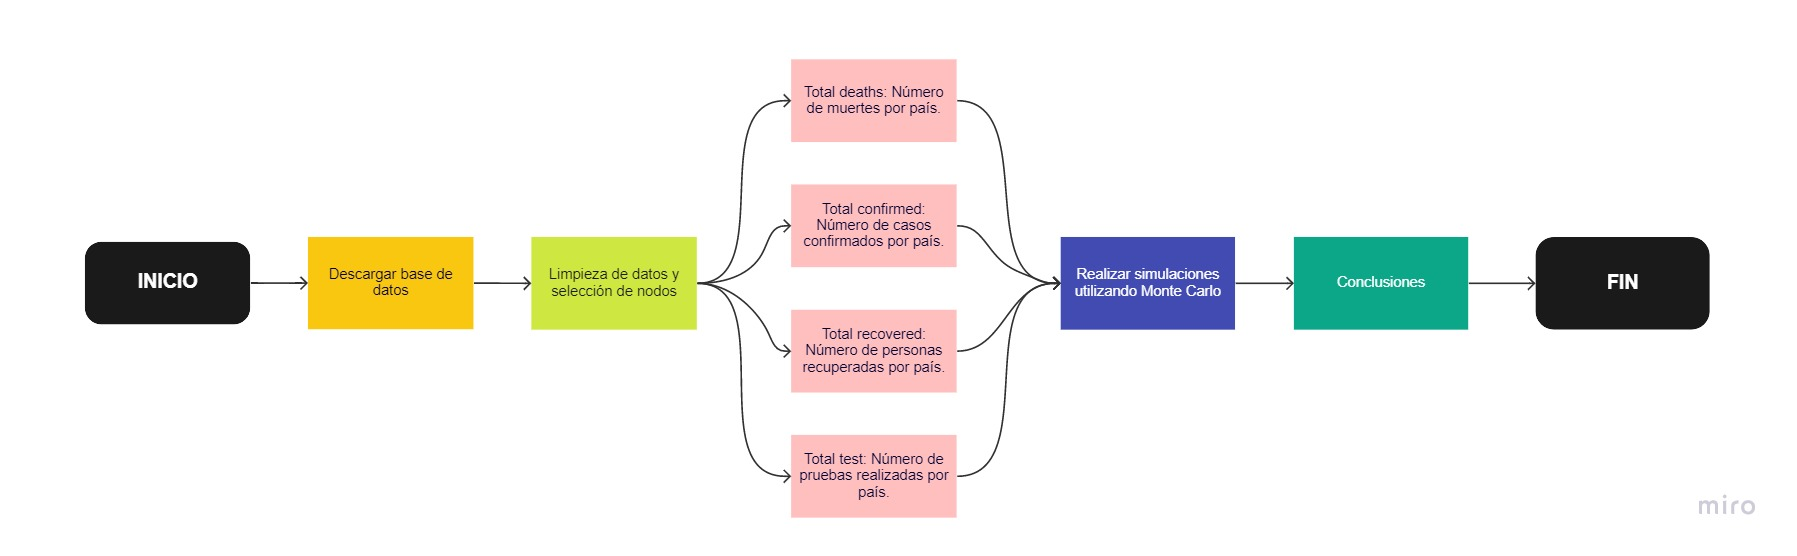
 